evaluate accuracy on different city

In [ ]:
!pip install segmentation_models
!pip install patchify

In [ ]:
# Connecting to the Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
%matplotlib inline

In [ ]:
from PIL import Image
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
from osgeo import gdal

In [ ]:
# import dataset for Philadelphia
# Open the file:
image_new = gdal.Open('location of Philadelphia tif image')
park_new = gdal.Open('location of Philadephia tif parks')

# turn into array
image_array_new = image_new.ReadAsArray()

image_array_new = np.transpose(image_array_new, [1, 2, 0]) # transpose the bands to the third dimension
print(image_array_new.shape)

park_array_new = park_new.ReadAsArray()
park_array_new = np.expand_dims(park_array_new, axis = 2)
print(park_array_new.shape)

(2895, 2739, 11)
(2894, 2738, 1)


In [ ]:
#leave only ndvi, landcover, NDBI
image_array_new = image_array_new[:,:,[4,5,10]]

In [ ]:
# cropping satellite image

#have to be the same as saved patches
patch_size = 256
step = 50
scaler = MinMaxScaler()
image_dataset_new = []  

patches_img = patchify(image_array_new, (patch_size, patch_size, 3), step=step)  
for i in range(patches_img.shape[0]):
  for j in range(patches_img.shape[1]):
    single_patch_img = patches_img[i,j,:,:]             
    single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
    single_patch_img = single_patch_img[0]                              
    image_dataset_new.append(single_patch_img) 

image_dataset_new = np.array(image_dataset_new)
print("The shape for image dataset is:", image_dataset_new.shape)

# cropping park dataset
park_dataset_new = []
patches_img = patchify(park_array_new, (patch_size, patch_size, 1), step=step)  
for i in range(patches_img.shape[0]):
  for j in range(patches_img.shape[1]):
    single_patch_img = patches_img[i,j,:,:]
    single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
    single_patch_img = single_patch_img[0]                             
    park_dataset_new.append(single_patch_img)

park_dataset_new = np.array(park_dataset_new)
print("The shape for park dataset is:", park_dataset_new.shape)

The shape for image dataset is: (2650, 256, 256, 3)
The shape for park dataset is: (2650, 256, 256, 1)


In [ ]:
from tensorflow.keras.optimizers import Adam
#from focal_loss import BinaryFocalLoss
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.metrics import MeanIoU

In [ ]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
model_test = load_model('location of saved model', compile = False)

model_test.compile(optimizer=Adam(learning_rate = 1e-4), loss = sm.losses.binary_focal_dice_loss, 
              metrics=['accuracy', sm.metrics.IOUScore(threshold=0.5), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) # use the same parameters as in original training!

In [ ]:
# precessing X to fit the model
import segmentation_models as sm
from tensorflow.keras.utils import to_categorical

BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)
X_test = preprocess_input(image_dataset_new)

# turn y to categorical data
test_masks_cat = to_categorical(park_dataset_new, num_classes=2)
y_test_cat = test_masks_cat.reshape((park_dataset_new.shape[0], 
                                     park_dataset_new.shape[1], 
                                     park_dataset_new.shape[2], 2))
print(X_test.shape, y_test_cat.shape)

(2650, 256, 256, 3) (2650, 256, 256, 2)


In [ ]:
# predict and metrics
loss, acc, IoU, precision, recall = model_test.evaluate(X_test, y_test_cat, verbose = 1)

print("Loss is ", loss)
print("Accuracy is ", acc)
print("IoU is ", IoU)
print("Precision is ", precision)
print("Recall is ", recall)

83/83 [==============================] - 82s 952ms/step - loss: 0.4687 - accuracy: 0.8788 - iou_score: 0.5902 - precision: 0.8764 - recall: 0.8823
Loss is  0.4687296748161316
Accuracy is  0.8788475394248962
IoU is  0.5902349352836609
Precision is  0.8763931393623352
Recall is  0.8823352456092834


In [ ]:
y_pred = model_test.predict(X_test)
y_pred.mean()

0.49488243

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

(1, 256, 256, 3)


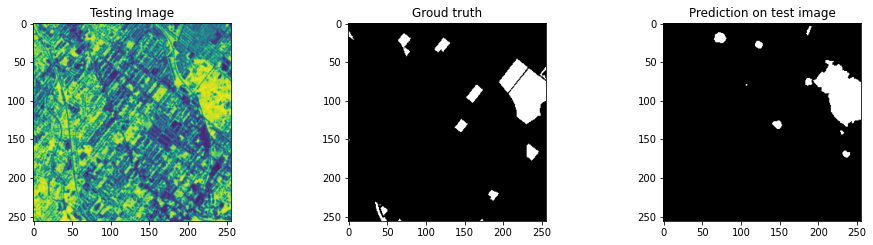

In [ ]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth = park_dataset_new[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
print(test_img_input.shape)

test_img_input1 = preprocess_input(test_img_input)

test_pred = model_test.predict(test_img_input1)
test_prediction = np.argmax(test_pred, axis=3)[0,:,:]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])

plt.subplot(232)
plt.title('Groud truth')
plt.imshow(ground_truth[:,:,0], cmap='gray')

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction, cmap='gray')

plt.show()